In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import make_blobs

%matplotlib inline
plt.style.use('seaborn-white')

10. This question should be answered using the Weekly data set, which is part of the ISLR package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

In [2]:
import os 

UP_DIR = '/Users/isabellachittumuri/Documents/Hunter College/Fall 2020/Stat 724/Jupyter/'
csv_file = os.path.join(UP_DIR,'Weekly.csv')

weekly = pd.read_csv(csv_file, header=0, index_col=0, squeeze=True)
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
2,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
3,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
4,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
5,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


(a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [3]:
# Make categorical outputs numerical
weekly['Direction'] = weekly.Direction.map({'Up':1,'Down':0})
weekly['Direction'].value_counts()

1    605
0    484
Name: Direction, dtype: int64

In [4]:
# Statistical summary 
weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899,0.555556
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927,0.497132
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000,0.000000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000,0.000000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000,1.000000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000,1.000000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000,1.000000


There seems to be no clear pattern among the variables.

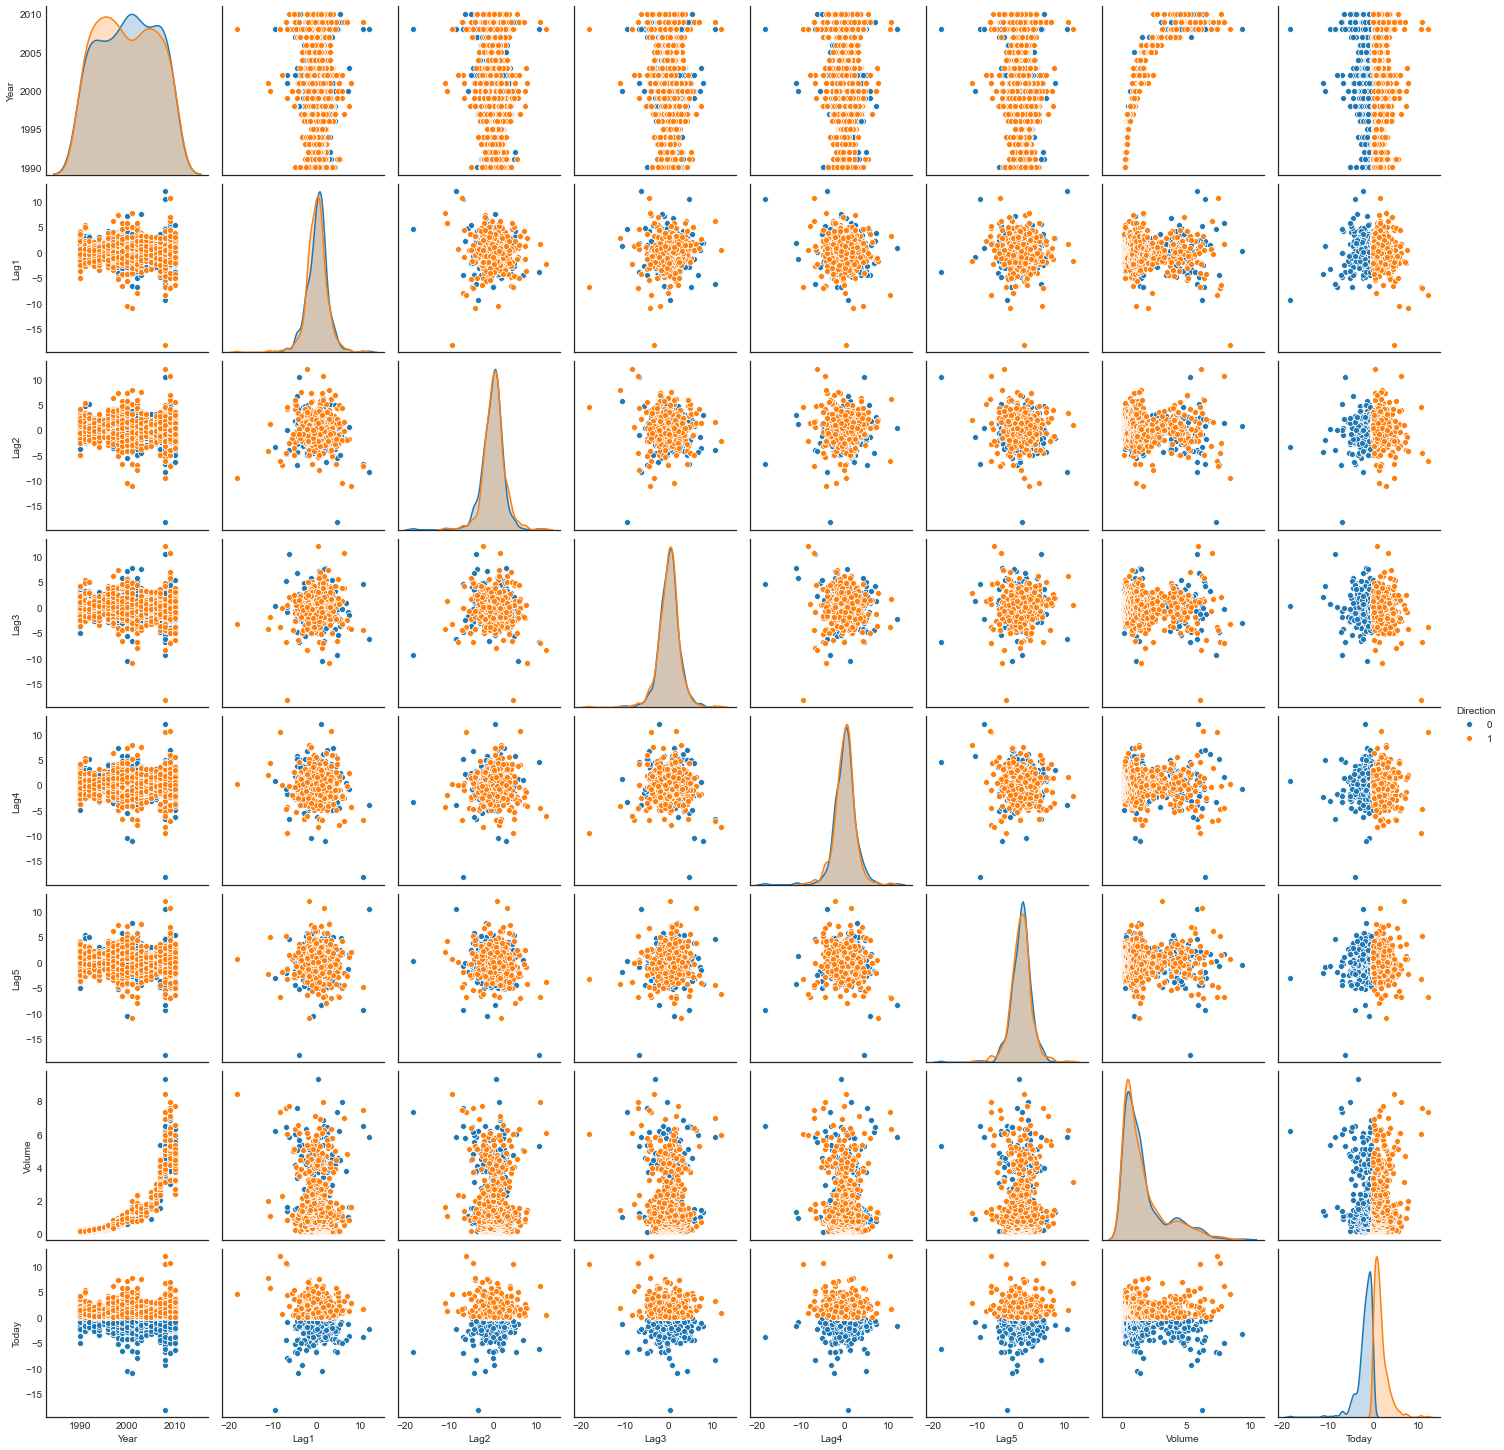

In [5]:
# Pairwise scatterplot
sns.pairplot(weekly, hue = "Direction");

From the pairwise plot, the only significant relationship we can see is between Volume and Year.

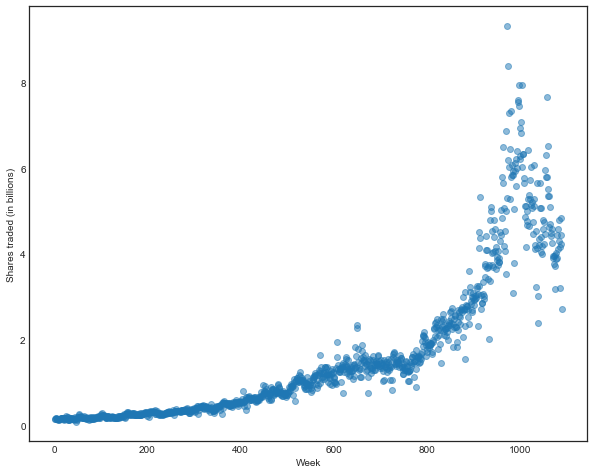

In [6]:
# Scatter plot of Volume and Year/Week
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(x = weekly.index, y = weekly["Volume"], alpha = 0.5)
ax.set(xlabel = "Week", ylabel = "Shares traded (in billions)");

Looking at the scatterplot of Volume over Week, we can see that the number of shares traded grew exponentially over the 21 years represented in the dataset.

In [7]:
# Pairwise Correlation
weekly.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460,-0.022200
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032,-0.050004
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167,0.072696
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244,-0.022913
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826,-0.020549
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013,-0.018168
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078,-0.017995
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000,0.720025
Direction,-0.022200,-0.050004,0.072696,-0.022913,-0.020549,-0.018168,-0.017995,0.720025,1.000000


From the pairwise correlation, we can confirm a strong correlation between Year and Volume with a value of 0.842. There is also a strong correlation between Today and Direction, as well as weak correlations between the lag variables.

(b) Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones? 

In [8]:
# Train data creates the model
# Test data tests the accuracy of the model
weekly_train = weekly[weekly['Year']<2007]
weekly_test = weekly[weekly['Year']>=2007]
weekly_test.describe

<bound method NDFrame.describe of       Year   Lag1   Lag2   Lag3   Lag4   Lag5    Volume  Today  Direction
881   2007  0.534 -1.144  1.224  0.940 -0.303  1.541113 -0.606          0
882   2007 -0.606  0.534 -1.144  1.224  0.940  3.117673  1.491          1
883   2007  1.491 -0.606  0.534 -1.144  1.224  2.822146 -0.016          0
884   2007 -0.016  1.491 -0.606  0.534 -1.144  2.722428 -0.582          0
885   2007 -0.582 -0.016  1.491 -0.606  0.534  2.783864  1.843          1
...    ...    ...    ...    ...    ...    ...       ...    ...        ...
1085  2010 -0.861  0.043 -2.173  3.599  0.015  3.205160  2.969          1
1086  2010  2.969 -0.861  0.043 -2.173  3.599  4.242568  1.281          1
1087  2010  1.281  2.969 -0.861  0.043 -2.173  4.835082  0.283          1
1088  2010  0.283  1.281  2.969 -0.861  0.043  4.454044  1.034          1
1089  2010  1.034  0.283  1.281  2.969 -0.861  2.707105  0.069          1

[209 rows x 9 columns]>

In [9]:
# Note: 80% of data in weekly_train, 20% of data in weekly_test
print('train size: {0}  test size {1}'.format(weekly_train.shape[0],weekly_test.shape[0]))

train size: 880  test size 209


In [10]:
# Use Direction as the response and the five lag variables plus Volume as predictors
X_train = weekly_train[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']]
y_train = weekly_train[['Direction']]
X_test = weekly_test[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']]
y_test = weekly_test[['Direction']]

In [11]:
# Create logistic regression model using train data (Statsmodel)
logit_mod = sm.Logit(y_train,X_train)
logit_res = logit_mod.fit()
print(logit_res.summary2())

Optimization terminated successfully.
         Current function value: 0.686158
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.000   
Dependent Variable: Direction        AIC:              1219.6372
Date:               2020-10-08 11:35 BIC:              1248.3167
No. Observations:   880              Log-Likelihood:   -603.82  
Df Model:           5                LL-Null:          -603.81  
Df Residuals:       874              LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
------------------------------------------------------------------
Lag1      -0.0294     0.0331   -0.8869   0.3752   -0.0943   0.0356
Lag2       0.0427     0.0333    1.2821   0.1998   -0.0226   0.1079
Lag

In [12]:
# From results, create matrix to see values more clearly 
# Statistically significant predictors have p-values < alpha levels 0.05 or 0.10 
pd.DataFrame({"Estimate": logit_res.params, "Std. Error": logit_res.bse, "z value": logit_res.tvalues,
             "Pr(>|z|)": logit_res.pvalues})

,Estimate,Std. Error,z value,Pr(>|z|)
Lag1,-0.029391,0.033141,-0.886857,0.375156
Lag2,0.042654,0.033269,1.282101,0.199807
Lag3,-0.011404,0.033172,-0.343791,0.731003
Lag4,-0.018885,0.033170,-0.569331,0.569132
Lag5,-0.057018,0.033122,-1.721451,0.085169
Volume,0.164606,0.063117,2.607946,0.009109


At alpha level 0.05, the only statistically significant predictor is Volume with a p-value of 0.009. At alpha level 0.10, Lag1, Lag2 and Lag5 are moderately significant with p-values of 0.375, 0.200, and 0.085 respectively. We reject the null hypothesis that all other predictors are significant to the response Direction, because their p-values are greater than both alpha levels.

(c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [13]:
# Logistic Regression
# Fit the model on the train data (scikit-learn estimation)
clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y_train.values.ravel())
print(clf)
print('classes: ',clf.classes_) 
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(solver='newton-cg')
classes:  [0 1]
coefficients:  [[-0.03779339  0.03209126 -0.02055011 -0.02786868 -0.06531854 -0.05651477]]
intercept : [0.30975832]


Classes are labels for the variable direction, where down is 0 and up is 1. 

Coefficients are the coefficients of the scikit-learn logistic regression model. It goes in order of the predictors, where Lag1 is the first coefficient and Volume is the last. 
- Notice, all the coefficients of this model decreased from that of our previous model where we used statsmodel. This is because the statsmodel does not include the intercept where as scikit-learn does. Still, most of these coefficients are similar to the previous model.

The intercept is the expected mean value of y_train (in this case direction) when all X_train=0.

In [14]:
# Confusion matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total Positive (Actual): ', np.sum(cm[1]))

In [15]:
# Variable to predict slk model using X_test perdictors
clf_pred = clf.predict(X_test)

# Find the training and test set score
print("Training accuracy score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test accuracy score: {:.3f}".format(clf.score(X_test,y_test)))

# Show the confusion matrix
cm_df = pd.DataFrame(confusion_matrix(y_test, clf_pred).T, index=clf.classes_,columns=clf.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('\nConfusion table:\n', cm_df)

# Additional statistics
print('\n',classification_report(y_test, clf_pred)) 

Training accuracy score: 0.561
Test accuracy score: 0.517

Confusion table:
 True        0   1
Predicted        
0          40  45
1          56  68

               precision    recall  f1-score   support

           0       0.47      0.42      0.44        96
           1       0.55      0.60      0.57       113

    accuracy                           0.52       209
   macro avg       0.51      0.51      0.51       209
weighted avg       0.51      0.52      0.51       209



True Negatives:  40
False Positives:  56
False Negatives:  45
True Positives:  68
Total Positive (Actual):  113


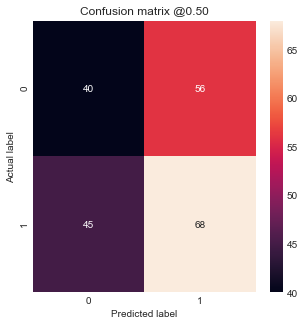

In [16]:
# Print(confusion_matrix(y_test, pred))
plot_cm(y_test, clf_pred)

Looking at the accuracy scores:

- In general, the model should always perform better on the training set than the testing set. This because the model was trained on the training data and not on the testing data. Intuitively, the model should perform better on data that it has seen before versus data it has not seen.
- Therefore, the test accuracy score with a value of 0.517 is lower than the training accuracy score with a value of  0.561. However, both of the scores are only about 50% accurate, which isn't that great.

Looking at the confusion table: 

- The number of true negatives (TN) is 40, meaning the model predicted negative when the case was negative (0,0). 
- The number of false positives (FP) is 56, meaning the model predicted positive when the case was negative (0,1). 
- The number of false negatives (FN) is 45, meaning the model predicted negative when the case was positive (1,0). 
- The number of true positives (TP) is 68, meaning the model predicted positive when the case was positive (1,1). 

Looking at the classification report:

- Precision is the ability of a classifier not to label an instance positive that is actually negative, or vice versa. Precision (1) = TP/(TP + FP) = 0.55 and Precision (0) = TN/(TN + FN) = 0.47
- Recall is the ability of a classifier to find all positive instances or all negatives. Recall (1) = TP/(TP+FN) = 0.42 or Recall (0) = TN/(TN+FP) = 0.60. This model has a higher recall for finding negatives.
- F1-score is the weighted harmonic mean of precision using both Precision and Recall; it's used to see if the dataset has an imbalanced distribution of the different classes. F1 Score = 2*((Recall * Precision) / (Recall + Precision)). For (1) = 0.57 and for (0) = 0.44
- Support is the number of actual occurrences of each class in the *y_test* dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process. In this case, support (1) = 96 and support (0) = 113

Looking at the averages: 

- Macro average is computed using each column's results and returns the average without considering the weights for each class. This can result in a bigger penalization when our model does not perform well with the minority classes, which is exactly what we want when there is imbalance. 
- Weighted average is computed using each column's results and returns the average considering the weights for each class. This favors the majority class, which is want we usually don't want.

    - Both the macro and weighted averages are relatively the same for all columns.

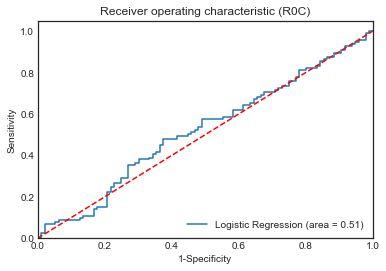

In [17]:
# ROC curve and AUC
clf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % clf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver operating characteristic (R0C)')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

This graph depicts the receiver operating characteristic curve (ROC). Specificity is the number of negatives we predicted correctly (TN) of the total amount of negatives. Sensitivity is the number of positives we predicted correctly (TP) of the total amount of positives. If our model did absolutely nothing, our ROC would align with the red dotted line. If our model was worse, it would go below the red dotted line. What we want is that ROC curve to be as close to the 1 on the y-axis as possible. 

The AUC is the area under the curve of the ROC. If we had a prefect model, our AUC would equal 1. Our actual ROC curve is inconsistent and very close to the red dotted line, with an AUC of 0.51. This suggests that our model isn't fitting the data well.

(d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [18]:
weekly_train_1 = weekly[weekly['Year']<2009]
weekly_test_1 = weekly[weekly['Year']>=2009]

In [19]:
X_train_1 = weekly_train_1[['Lag2']]
y_train_1 = weekly_train_1['Direction']
X_test_1 = weekly_test_1[['Lag2']]
y_test_1 = weekly_test_1['Direction']

In [20]:
logit_mod = sm.Logit(y_train_1,X_train_1)
logit_res = logit_mod.fit()
print(logit_res.summary2())

Optimization terminated successfully.
         Current function value: 0.690654
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.004   
Dependent Variable: Direction        AIC:              1362.5887
Date:               2020-10-08 11:35 BIC:              1367.4813
No. Observations:   985              Log-Likelihood:   -680.29  
Df Model:           0                LL-Null:          -677.35  
Df Residuals:       984              LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
-------------------------------------------------------------------
         Coef.     Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
Lag2     0.0629      0.0287    2.1920    0.0284    0.0067    0.1191



We see that Lag2 has a p-value of 0.0284, meaning that it is a significant predictor of Direction.

In [21]:
# Logistic Regression
# Fit the model on the train data
clf_1 = skl_lm.LogisticRegression(solver='newton-cg')
clf_1.fit(X_train_1,y_train_1)
print('classes: ',clf_1.classes_)
print('coefficients: ',clf_1.coef_)
print('intercept :', clf_1.intercept_)

classes:  [0 1]
coefficients:  [[0.05804744]]
intercept : [0.20326236]


In [22]:
clf_pred_1 = clf_1.predict(X_test_1)

# Find the accuracy of the test predictions vs the true classes
print("Training accuracy score: {:.3f}".format(clf_1.score(X_train_1,y_train_1)))
print("Test accuracy score: {:.3f}".format(clf_1.score(X_test_1,y_test_1)))

# Show the confusion matrix
#print(confusion_matrix(y_test, pred))
cm_df = pd.DataFrame(confusion_matrix(y_test_1, clf_pred_1).T, index=clf_1.classes_,columns=clf_1.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('\nConfusion table:\n', cm_df)

# Additional statistics
print('\n',classification_report(y_test_1, clf_pred_1))

Training accuracy score: 0.555
Test accuracy score: 0.625

Confusion table:
 True        0   1
Predicted        
0           9   5
1          34  56

               precision    recall  f1-score   support

           0       0.64      0.21      0.32        43
           1       0.62      0.92      0.74        61

    accuracy                           0.62       104
   macro avg       0.63      0.56      0.53       104
weighted avg       0.63      0.62      0.57       104



True Negatives:  9
False Positives:  34
False Negatives:  5
True Positives:  56
Total Positive (Actual):  61


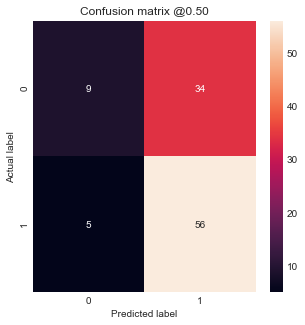

In [23]:
# Print(confusion_matrix(y_test, pred))
plot_cm(y_test_1, clf_pred_1)

The test accuracy score with a value of 0.625 is higher than the training accuracy score with a value of 0.555. This means that our model correctly predicted the market direction for 62.5% of the weeks in our test data. While this is better than chance, it still is less than a 10% improvement from our model in Part (c). 

Our model's positive predictive value (precision) is 0.622, with the negative predictive value is 0.64. These two values are relatively the same. The true positive rate (recall) is .92, while the true negative rate is 0.21. This means our model was able to find more positive instances than negative. Over all, based on our F1-score, our model's accuracy on predicting positive values is 0.74, while its accuracy on predicating negative values is 0.32. This is not that bad, since we would rather have a higher accuracy for positive values.

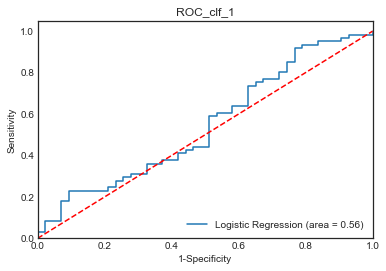

In [24]:
# ROC curve and AUC
clf_roc_auc_1 = roc_auc_score(y_test_1, clf_1.predict(X_test_1))
fpr, tpr, thresholds = roc_curve(y_test_1, clf_1.predict_proba(X_test_1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % clf_roc_auc_1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC_clf_1')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Our ROC curve for this model is better than the one in Part (c), because it looks to be more positively differentiated from the red dotted line. It also has a bigger AUC value of 0.56.

(e) Repeat (d) using LDA.

In [25]:
# Linear Discriminant Analysis
# Fit the model on the train data using LDA
lda = LinearDiscriminantAnalysis()
lda_pred = lda.fit(X_train_1, y_train_1).predict(X_test_1)

print(lda.means_)

# Find the accuracy of the test predictions vs the true classes
print("Training accuracy score: {:.3f}".format(lda.score(X_train_1,y_train_1)))
print("Test accuracy score: {:.3f}".format(lda.score(X_test_1,y_test_1)))

# Show the confusion matrix
cm_df = pd.DataFrame(confusion_matrix(y_test_1, lda_pred).T, index=clf_1.classes_,columns=clf_1.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('\nConfusion table:\n', cm_df)

# Additional statistics
print('\n',classification_report(y_test_1, lda_pred))

[[-0.03568254]
 [ 0.26036581]]
Training accuracy score: 0.554
Test accuracy score: 0.625

Confusion table:
 True        0   1
Predicted        
0           9   5
1          34  56

               precision    recall  f1-score   support

           0       0.64      0.21      0.32        43
           1       0.62      0.92      0.74        61

    accuracy                           0.62       104
   macro avg       0.63      0.56      0.53       104
weighted avg       0.63      0.62      0.57       104



True Negatives:  9
False Positives:  34
False Negatives:  5
True Positives:  56
Total Positive (Actual):  61


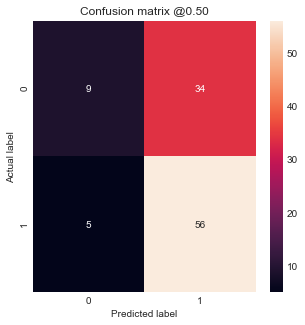

In [26]:
# Print(confusion_matrix(y_test_1, lda_pred))
plot_cm(y_test_1, lda_pred)

After performing linear discriminant analysis on the model, we end up with an identical confusion matrix to the one in Part (d), using the logistic regression model. As we saw in Part (d), our correctly predicted the market direction for 62.5% of the weeks in the test data. And over all, our model's accuracy on predicting positive values is 0.74, while its accuracy on predicating negative values is 0.32.

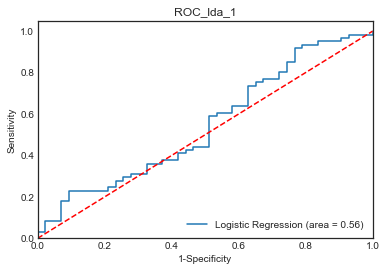

In [27]:
# LDA - ROC curve and AUC
lda_roc_auc_1 = roc_auc_score(y_test_1, lda.predict(X_test_1))
fpr, tpr, thresholds = roc_curve(y_test_1, lda.predict_proba(X_test_1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lda_roc_auc_1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC_lda_1')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Our ROC curve is also identical to the model in Part (d), with an AUC value of 0.56.

(f) Repeat (d) using QDA.

In [28]:
# Quadratic discriminant analysis
# Fit the model on the train data using QDA
qda = QuadraticDiscriminantAnalysis()
qda_pred = qda.fit(X_train_1, y_train_1).predict(X_test_1)

print(qda.means_)

# Find the accuracy of the test predictions vs the true classes
print("Training accuracy score: {:.3f}".format(qda.score(X_train_1,y_train_1)))
print("Test accuracy score: {:.3f}".format(qda.score(X_test_1,y_test_1)))

# Show the confusion matrix
cm_df = pd.DataFrame(confusion_matrix(y_test_1, qda_pred).T, index=clf_1.classes_,columns=clf_1.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('\nConfusion table:\n', cm_df)

# Additional statistics
print('\n',classification_report(y_test_1, qda_pred))

[[-0.03568254]
 [ 0.26036581]]
Training accuracy score: 0.552
Test accuracy score: 0.587

Confusion table:
 True        0   1
Predicted        
0           0   0
1          43  61

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.59      1.00      0.74        61

    accuracy                           0.59       104
   macro avg       0.29      0.50      0.37       104
weighted avg       0.34      0.59      0.43       104



/Users/isabellachittumuri/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


True Negatives:  0
False Positives:  43
False Negatives:  0
True Positives:  61
Total Positive (Actual):  61


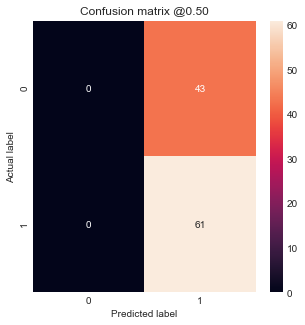

In [29]:
# Print(confusion_matrix(y_test_1, qda_pred))
plot_cm(y_test_1, qda_pred)

After performing quadratic discriminant analysis on the model, the test accuracy score with a value of 0.587 was only slightly higher than the training accuracy score with a value of 0.552. This means, using QDA, our model correctly predicted the market direction for 58.7% of the weeks in our test data. This is less accurate than when we used QDA.

Our model's positive predictive value is 0.59, with the negative predictive value is 0.00. This model only tested for positive values, disregarding the negatives, which is why the F1-score for positives is high. However, this model can be misleading overall because it doesn’t incorporate the negatives at all.

There is also an imbalance between the macro and weighted average. The weighted average is higher, confirming that our models favors the majority class. 

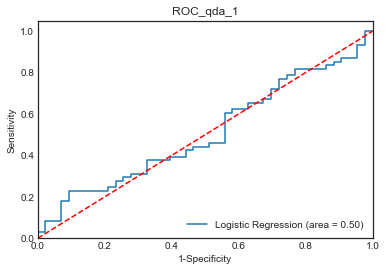

In [30]:
# QDA - ROC curve and AUC
qda_roc_auc_1 = roc_auc_score(y_test_1, qda.predict(X_test_1))
fpr, tpr, thresholds = roc_curve(y_test_1, qda.predict_proba(X_test_1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % qda_roc_auc_1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC_qda_1')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Our ROC using QDA isn't consistent. We see that half of the curve will dip below the dotted line and half of the curve will peak above the dotted line. It makes sense why our AUC is 0.50.

(g) Repeat (d) using KNN with K = 1.

In [31]:
# k-nearest neighbors with  k=1, the method is equivalent to a random choice
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn_pred = knn.fit(X_train_1, y_train_1).predict(X_test_1)

# Find the accuracy of the test predictions vs the true classes
print("Training accuracy score: {:.3f}".format(knn.score(X_train_1,y_train_1)))
print("Test accuracy score: {:.3f}".format(knn.score(X_test_1,y_test_1)))

# Show the confusion matrix
cm_df = pd.DataFrame(confusion_matrix(y_test_1, knn_pred).T, index=clf_1.classes_,columns=clf_1.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('\nConfusion table:\n', cm_df)

# Additional statistics
print('\n',classification_report(y_test_1, knn_pred))

Training accuracy score: 0.957
Test accuracy score: 0.490

Confusion table:
 True        0   1
Predicted        
0          21  31
1          22  30

               precision    recall  f1-score   support

           0       0.40      0.49      0.44        43
           1       0.58      0.49      0.53        61

    accuracy                           0.49       104
   macro avg       0.49      0.49      0.49       104
weighted avg       0.51      0.49      0.49       104



True Negatives:  21
False Positives:  22
False Negatives:  31
True Positives:  30
Total Positive (Actual):  61


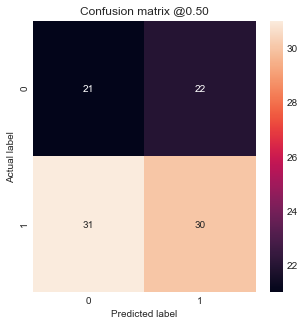

In [32]:
# Print(confusion_matrix(y_test_1, knn_pred))
plot_cm(y_test_1, knn_pred)

After performing  k-nearest neighbors classification with  k=1  on the model, we see that the training accuracy score is really high with a value of .957. However, the test accuracy score is a lot lower than the training with a value 0.49. This means that the model was only about 50% accurate in predicting the test data. Our precision, recall and F1-scores all confirm this accuracy.

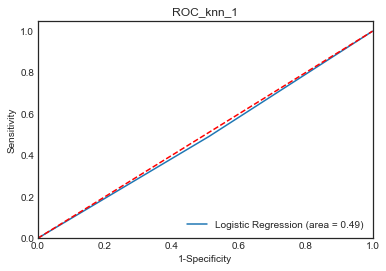

In [33]:
# KNN - ROC curve and AUC
knn_roc_auc_1 = roc_auc_score(y_test_1, knn.predict(X_test_1))
fpr, tpr, thresholds = roc_curve(y_test_1, knn.predict_proba(X_test_1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % knn_roc_auc_1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC_knn_1')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Looking at the ROC curve for knn=1, we see that our model does nothing significant in predicting the test data, because it is so closely aligned with the red dotted line. If we look more closely, we can see that toward the middle of the graph, the ROC lines slightly dips below the red line. This means it is actually performing worse than randomly guessing.

(h) Which of these methods appears to provide the best results on
this data?

Considering overall prediction accuracy, the logistic regression and linear discriminant analysis were equally good at fitting the data, with an accuracy of 62.5%, providing the best results on this data. Quadratic discriminant analysis had an accuracy of 58.7%, k-nearest neighbors with  k=1 had an accuracy 49%. 

Note the first three models favored predicting positive rates which means they favored predicting the up weeks. However, because of this, they also had high false positive rates. In creating a model, we have to take into account our audience and understand if an investor is okay with losing money on a down week that was falsely predicted as an up week. If not, an investor would probably  want a model with a significantly higher accuracy then about 50%. 

(i) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

In [34]:
weekly_train_ex = weekly[weekly['Year']<2007]
weekly_test_ex = weekly[weekly['Year']>=2007]

In [35]:
X_train_ex = weekly_train_ex[['Lag1','Lag2','Lag5','Volume']]
y_train_ex = weekly_train_ex[['Direction']]
X_test_ex = weekly_test_ex[['Lag1','Lag2','Lag5','Volume']]
y_test_ex = weekly_test_ex[['Direction']]

We used Lag1, Lag1, Lag5 and Volume because these predictors have the highest significant p-value compared to the other predictors, seen in part (b) and below.

In [36]:
logit_mod_ex = sm.Logit(y_train_ex,X_train_ex)
logit_res_ex = logit_mod_ex.fit()
print(logit_res_ex.summary2())

Optimization terminated successfully.
         Current function value: 0.686395
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.000   
Dependent Variable: Direction        AIC:              1216.0551
Date:               2020-10-08 11:35 BIC:              1235.1748
No. Observations:   880              Log-Likelihood:   -604.03  
Df Model:           3                LL-Null:          -603.81  
Df Residuals:       876              LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
------------------------------------------------------------------
Lag1      -0.0295     0.0331   -0.8908   0.3730   -0.0943   0.0354
Lag2       0.0425     0.0331    1.2829   0.1995   -0.0224   0.1075
Lag

In [37]:
weighted_avg = -0.0295*weekly["Lag1"] + 0.0425*weekly["Lag2"] + -0.0562*weekly["Lag5"] + 0.1619*weekly["Volume"]
weekly["weighted_avg"] = weighted_avg
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,weighted_avg
1,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,0,0.263629
2,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,0,0.079569
3,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,1,0.311598
4,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,1,-0.275322
5,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,1,0.107370


We multiplied each variable with its corresponding estimate (coefficients) to transform the predictors. 

In [38]:
weekly_train_exp = weekly[weekly['Year']<2007]
weekly_test_exp = weekly[weekly['Year']>=2007]

In [39]:
X_train_exp = weekly_train_exp[['weighted_avg']]
y_train_exp = weekly_train_exp[['Direction']]
X_test_exp = weekly_test_exp[['weighted_avg']]
y_test_exp = weekly_test_exp[['Direction']]

In [40]:
logit_mod_exp = sm.Logit(y_train_exp,X_train_exp)
logit_res_exp = logit_mod_exp.fit()
print(logit_res_exp.summary2())

Optimization terminated successfully.
         Current function value: 0.686395
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.000   
Dependent Variable: Direction        AIC:              1210.0551
Date:               2020-10-08 11:35 BIC:              1214.8350
No. Observations:   880              Log-Likelihood:   -604.03  
Df Model:           0                LL-Null:          -603.81  
Df Residuals:       879              LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
-----------------------------------------------------------------
                 Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
weighted_avg     1.0001    0.2934  3.4083  0.0007  0.4250  1.5751



We can see that weighted_avg is very significant with a p-value of 0.0007

In [41]:
# Logistic Regression
# Fit the model on the train data (scikit-learn estimation)
clf_exp= skl_lm.LogisticRegression(solver='newton-cg')
clf_exp.fit(X_train_exp,y_train_exp.values.ravel())
print(clf)
print('classes: ',clf_exp.classes_) 
print('coefficients: ',clf_exp.coef_)
print('intercept :', clf_exp.intercept_)

LogisticRegression(solver='newton-cg')
classes:  [0 1]
coefficients:  [[0.55701684]]
intercept : [0.16454781]


In [42]:
# Variable to predict lm model using X_test perdictors
clf_pred_exp = clf_exp.predict(X_test_exp)

# Find the accuracy of the predictions against the true classes
print("Training accuracy score: {:.3f}".format(clf_exp.score(X_train_exp,y_train_exp)))
print("Test accuracy score: {:.3f}".format(clf_exp.score(X_test_exp,y_test_exp)))

# Show the confusion matrix
cm_df = pd.DataFrame(confusion_matrix(y_test_exp, clf_pred_exp).T, index=clf_exp.classes_,columns=clf_exp.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('\nConfusion table:\n', cm_df)

# Additional statistics
print('\n',classification_report(y_test_exp, clf_pred_exp)) 

Training accuracy score: 0.557
Test accuracy score: 0.545

Confusion table:
 True        0    1
Predicted         
0           1    0
1          95  113

               precision    recall  f1-score   support

           0       1.00      0.01      0.02        96
           1       0.54      1.00      0.70       113

    accuracy                           0.55       209
   macro avg       0.77      0.51      0.36       209
weighted avg       0.75      0.55      0.39       209



True Negatives:  1
False Positives:  95
False Negatives:  0
True Positives:  113
Total Positive (Actual):  113


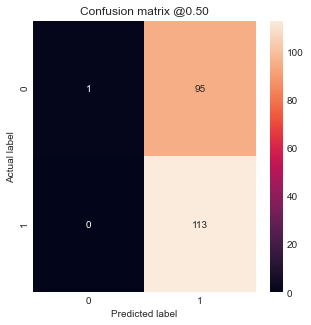

In [43]:
# Print(confusion_matrix(y_test_exp, clf_pred_exp))
plot_cm(y_test_exp, clf_pred_exp)

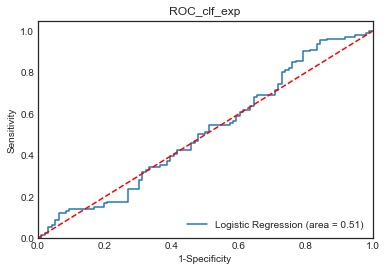

In [44]:
# Exp, ROC curve and AUC
clf_roc_auc_exp = roc_auc_score(y_test_exp, clf_exp.predict(X_test_exp))
fpr, tpr, thresholds = roc_curve(y_test_exp, clf_exp.predict_proba(X_test_exp)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % clf_roc_auc_exp)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC_clf_exp')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Using logistic regression for our experiential model, our training and test accuracy are very close in value around 0.55. It seems to be more geared to predicting positives, and therefore has a high recall rate of 1.00. However, it only predicted 1 true negative. Overall, our model's accuracy in predicting positive values is 0.7. We see that our ROC curve is inconsistent, with an AUC of 0.51. 

Note, we will not be using LDA because it's output is exactly the same as the logistic regression

In [45]:
# Quadratic discriminant analysis
# Fit the model on the train data using QDA
qda = QuadraticDiscriminantAnalysis()
qda_pred_exp = qda.fit(X_train_exp, y_train_exp).predict(X_test_exp)

print(qda.means_)

# Find the accuracy of the test predictions vs the true classes
print("Training accuracy score: {:.3f}".format(qda.score(X_train_exp,y_train_exp)))
print("Test accuracy score: {:.3f}".format(qda.score(X_test_exp,y_test_exp)))

# Show the confusion matrix
cm_df = pd.DataFrame(confusion_matrix(y_test_exp, qda_pred_exp).T, index=clf_exp.classes_,columns=clf_exp.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('\nConfusion table:\n', cm_df)

# Additional statistics
print('\n',classification_report(y_test_exp, qda_pred_exp))

[[0.11906515]
 [0.14257551]]
Training accuracy score: 0.559
Test accuracy score: 0.541

Confusion table:
 True        0    1
Predicted         
0           0    0
1          96  113

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.54      1.00      0.70       113

    accuracy                           0.54       209
   macro avg       0.27      0.50      0.35       209
weighted avg       0.29      0.54      0.38       209



/Users/isabellachittumuri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/isabellachittumuri/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


True Negatives:  0
False Positives:  96
False Negatives:  0
True Positives:  113
Total Positive (Actual):  113


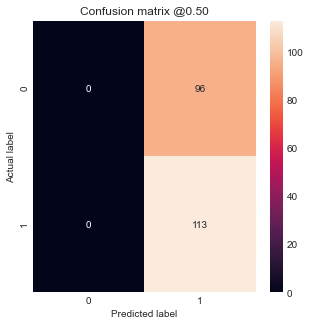

In [46]:
# Print(confusion_matrix(y_test_exp, qda_pred_exp))
plot_cm(y_test_exp, qda_pred_exp)

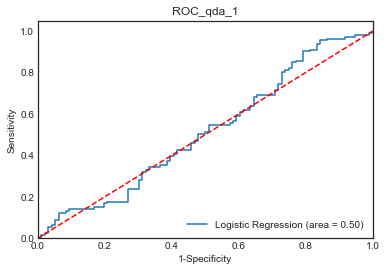

In [47]:
# Exp, QDA - ROC curve and AUC
qda_roc_auc_exp = roc_auc_score(y_test_exp, qda.predict(X_test_exp))
fpr, tpr, thresholds = roc_curve(y_test_exp, qda.predict_proba(X_test_exp)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % qda_roc_auc_exp)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC_qda_1')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

As we're seen in Part (f), quadratic discriminant analysis model only tested for positive values, disregarding the negatives. However, it's accuracy score is still only about 50%, with an F1-score of 0.70.

In [48]:
# k-nearest neighbors with  k=3
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn_pred_exp = knn.fit(X_train_exp, y_train_exp).predict(X_test_exp)

# Find the accuracy of the test predictions vs the true classes
print("Training accuracy score: {:.3f}".format(knn.score(X_train_exp,y_train_exp)))
print("Test accuracy score: {:.3f}".format(knn.score(X_test_exp,y_test_exp)))

# Show the confusion matrix
cm_df = pd.DataFrame(confusion_matrix(y_test_exp, knn_pred_exp).T, index=clf_exp.classes_,columns=clf_exp.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('\nConfusion table:\n', cm_df)

# Additional statistics
print('\n',classification_report(y_test_exp, knn_pred_exp))

Training accuracy score: 0.739
Test accuracy score: 0.507

Confusion table:
 True        0   1
Predicted        
0          24  31
1          72  82

               precision    recall  f1-score   support

           0       0.44      0.25      0.32        96
           1       0.53      0.73      0.61       113

    accuracy                           0.51       209
   macro avg       0.48      0.49      0.47       209
weighted avg       0.49      0.51      0.48       209



<ipython-input-48-14a977500157>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_pred_exp = knn.fit(X_train_exp, y_train_exp).predict(X_test_exp)


True Negatives:  24
False Positives:  72
False Negatives:  31
True Positives:  82
Total Positive (Actual):  113


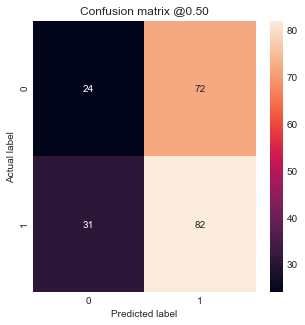

In [49]:
# Print(confusion_matrix(y_test_exp, knn_pred_exp))
plot_cm(y_test_exp, knn_pred_exp)

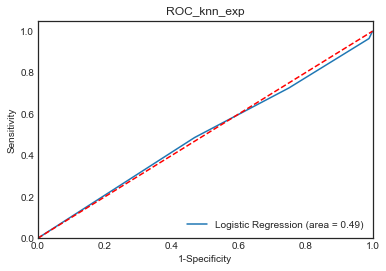

In [50]:
# Exp, KNN=3 - ROC curve and AUC
knn_roc_auc_exp = roc_auc_score(y_test_exp, knn.predict(X_test_exp))
fpr, tpr, thresholds = roc_curve(y_test_exp, knn.predict_proba(X_test_exp)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % knn_roc_auc_exp)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC_knn_exp')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

After performing k-nearest neighbors classification with  k=3, we see that this model takes into account both negatives and positives. But it is only really accurate in predicting positives, with a recall score of 0.73.

In [51]:
# k-nearest neighbors with  k=8
knn = neighbors.KNeighborsClassifier(n_neighbors=8)
knn_pred_exp = knn.fit(X_train_exp, y_train_exp).predict(X_test_exp)

# Find the accuracy of the test predictions vs the true classes
print("Training set score: {:.3f}".format(knn.score(X_train_exp,y_train_exp)))
print("Test set score: {:.3f}".format(knn.score(X_test_exp,y_test_exp)))

# Show the confusion matrix
cm_df = pd.DataFrame(confusion_matrix(y_test_exp, knn_pred_exp).T, index=clf.classes_,columns=clf.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('\nConfusion table:\n', cm_df)

# Additional statistics
print('\n',classification_report(y_test_exp, knn_pred_exp))

Training set score: 0.672
Test set score: 0.493

Confusion table:
 True        0   1
Predicted        
0          67  77
1          29  36

               precision    recall  f1-score   support

           0       0.47      0.70      0.56        96
           1       0.55      0.32      0.40       113

    accuracy                           0.49       209
   macro avg       0.51      0.51      0.48       209
weighted avg       0.51      0.49      0.48       209



<ipython-input-51-a970ba5d06f4>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_pred_exp = knn.fit(X_train_exp, y_train_exp).predict(X_test_exp)


True Negatives:  67
False Positives:  29
False Negatives:  77
True Positives:  36
Total Positive (Actual):  113


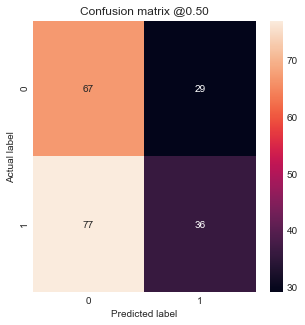

In [52]:
# Print(confusion_matrix(y_test_exp, knn_pred_exp))
plot_cm(y_test_exp, knn_pred_exp)

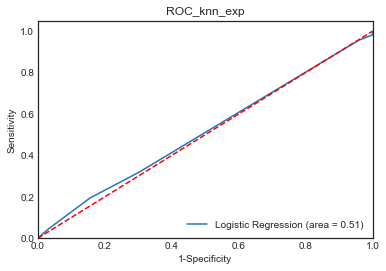

In [53]:
# Exp, KNN=8 - ROC curve and AUC
knn_roc_auc_exp = roc_auc_score(y_test_exp, knn.predict(X_test_exp))
fpr, tpr, thresholds = roc_curve(y_test_exp, knn.predict_proba(X_test_exp)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % knn_roc_auc_exp)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC_knn_exp')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

After performing k-nearest neighbors classification with  k=3 and k=8, we see that both models are performing pretty equally for predicting both positives and negatives. Both of their ROC curves and AUC values look similar. However, k=3 is a bit more accurate in preforming positives, while k=8 is slightly more accurate in preforming negatives. Because both make up for each other's weaknesses, we would prefer to implement both models when working with an investor. If we only want to predict positives, we would use the quadratic discriminant analysis. 

Overall, using the estimates to transform the predictors created a more accurate model.